In [1]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_models import TwoHemiRNNTanh_asymmetric_single_readout
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


In [3]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_0.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

# print(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())


Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_asymmetric_fixed_input/n_neurons_128_random_seed_0/unfix_epoch_0/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_0.pth


RuntimeError: Error(s) in loading state_dict for TwoHemiRNNTanh_single_readout:
	size mismatch for rnn_cell.w_hh_linear_ll.weight: copying a param with shape torch.Size([2, 2]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for rnn_cell.w_hh_linear_ll.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for rnn_cell.w_hh_linear_rr.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for rnn_cell.w_hh_linear_rr.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for rnn_cell.w_hh_linear_lr.weight: copying a param with shape torch.Size([128, 2]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for rnn_cell.w_hh_linear_rl.weight: copying a param with shape torch.Size([2, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for w_xh_linear_left_alm.weight: copying a param with shape torch.Size([2, 2]) from checkpoint, the shape in current model is torch.Size([64, 2]).
	size mismatch for w_xh_linear_right_alm.weight: copying a param with shape torch.Size([128, 2]) from checkpoint, the shape in current model is torch.Size([64, 2]).
	size mismatch for readout_linear.weight: copying a param with shape torch.Size([1, 130]) from checkpoint, the shape in current model is torch.Size([1, 128]).

In [130]:
exp = DualALMRNNExp()


# for seed in [0,1,2,3,4,5]:
for seed in [70]:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_256_random_seed_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_modular_asymmetric_fixed_input/n_neurons_256_random_seed_70/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'

### Add pre-learned hemi to left side

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_asymmetric_fixed_input/n_neurons_128_random_seed_0/unfix_epoch_40/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_8.pth
0.0006228288693819195 3.0410686429822817
0.0 51.48084
2.0 128.0


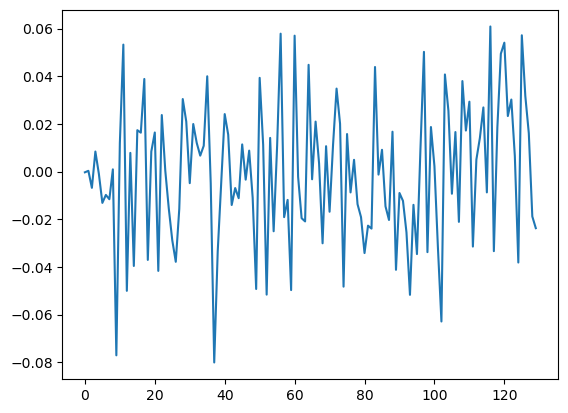

In [36]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = TwoHemiRNNTanh_asymmetric_single_readout(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_8.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
recurrent_weights_r = model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
input_weights_r = model.w_xh_linear_right_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

plt.plot(readout_weights.flatten())
print(sum(np.abs(readout_weights.flatten()[:2])), sum(np.abs(readout_weights.flatten()[2:])))
print(np.sum(np.abs(recurrent_weights)), np.sum(np.abs(recurrent_weights_r)))
print(np.sum(np.abs(input_weights)), np.sum(np.abs(input_weights_r)))
# print(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())


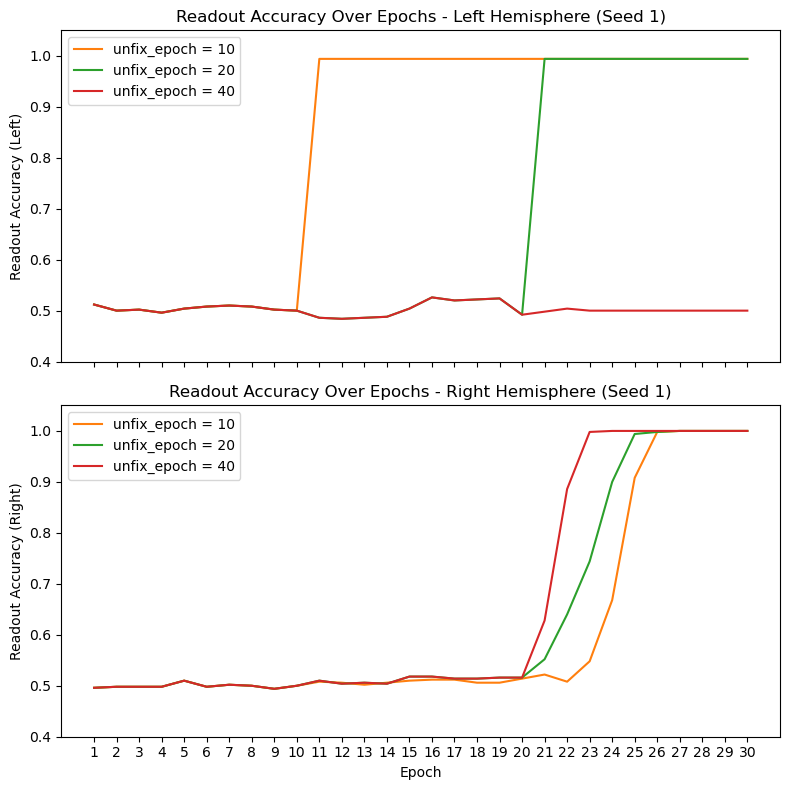

In [47]:
# Plot both unfix_epoch=0 and unfix_epoch=10 for this seed
seed = 1

fig, (ax_left, ax_right) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

unfix_epochs_to_compare = [ 10,20, 40]
colors = {1: 'tab:blue', 10: 'tab:orange', 20: 'tab:green', 40: 'tab:red'}
labels = {1: 'unfix_epoch = 1', 10: 'unfix_epoch = 10', 20: 'unfix_epoch = 20', 40: 'unfix_epoch = 40'}
readout_accs_left = {}
readout_accs_right = {}
epochs_dict = {}

for unfix_epoch in unfix_epochs_to_compare:
    # Load results_dict for each unfix_epoch
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_128_random_seed_{}/unfix_epoch_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            unfix_epoch,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict)+1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])
    readout_accs_left[unfix_epoch] = readout_acc_left
    readout_accs_right[unfix_epoch] = readout_acc_right
    epochs_dict[unfix_epoch] = epochs

    # Plot for left accuracy
    ax_left.plot(epochs, readout_acc_left, color=colors[unfix_epoch], label=labels[unfix_epoch])
    # Plot for right accuracy
    ax_right.plot(epochs, readout_acc_right, color=colors[unfix_epoch], label=labels[unfix_epoch])

ax_left.set_ylabel('Readout Accuracy (Left)')
ax_left.set_title(f'Readout Accuracy Over Epochs - Left Hemisphere (Seed {seed})')
ax_left.set_xticks(epochs)
ax_left.set_ylim(0.4, 1.05)
ax_left.legend()

ax_right.set_ylabel('Readout Accuracy (Right)')
ax_right.set_xlabel('Epoch')
ax_right.set_title(f'Readout Accuracy Over Epochs - Right Hemisphere (Seed {seed})')
ax_right.set_xticks(epochs)
ax_right.set_ylim(0.4, 1.05)
ax_right.legend()

plt.tight_layout()
plt.show()


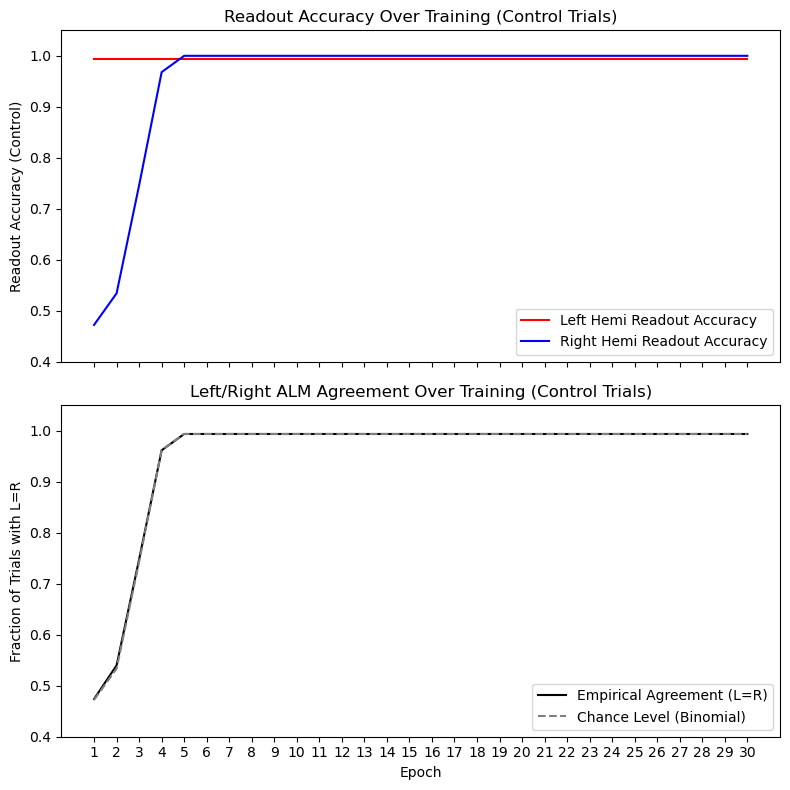

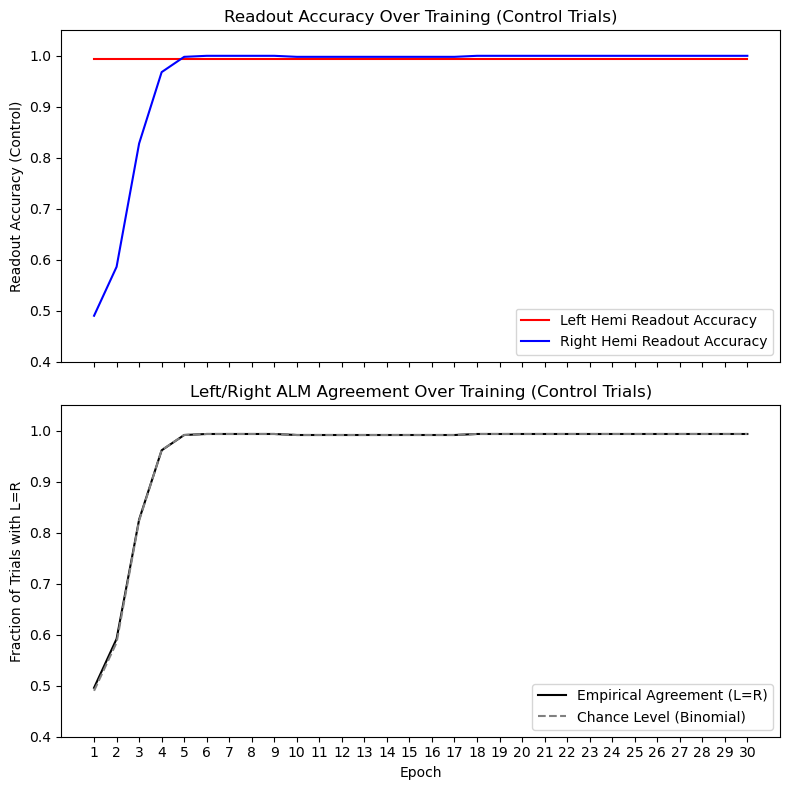

In [ ]:
exp = DualALMRNNExp()


# for seed in [0,1,2,3,4,5]:
for seed in [0]:
    epoch = 0
    for epoch in [0,10]:
        results_dict = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_128_random_seed_{}/unfix_epoch_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                exp.configs['train_type'],
                seed,
                epoch,
                float(exp.configs['xs_left_alm_amp']),
                float(exp.configs['xs_right_alm_amp'])
            ),
            allow_pickle=True
        )
        epochs = np.arange(1, len(results_dict) + 1)
        readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
        readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

        n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
        n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
        agreement_frac = n_trials_agreed / n_trials

        # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
        chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

        corruption_start_epoch = exp.configs['corruption_start_epoch']

 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()

torch.Size([500, 125, 2])

## Cross hemi weights

In [11]:
exp.sub_path

'train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_2/unfix_epoch_0/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20'

In [15]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_11.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

print(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())


Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_0/unfix_epoch_10/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_11.pth
[[ 0.00080174  0.0007931   0.00078897 ... -0.00080012 -0.00080652
   0.00080205]
 [-0.00080461 -0.00080034 -0.00079792 ...  0.00079637  0.00080749
  -0.00080434]
 [ 0.00080377  0.0007955   0.00079593 ... -0.00079793 -0.00080818
   0.00080005]
 ...
 [ 0.00075905  0.00062459 -0.00077567 ...  0.00078264  0.00063545
   0.00080226]
 [-0.0008071  -0.00080704 -0.00078152 ...  0.00076475  0.00080079
  -0.00080772]
 [ 0.00079208  0.00078604  0.00080319 ... -0.000807   -0.0008003
   0.00078702]]


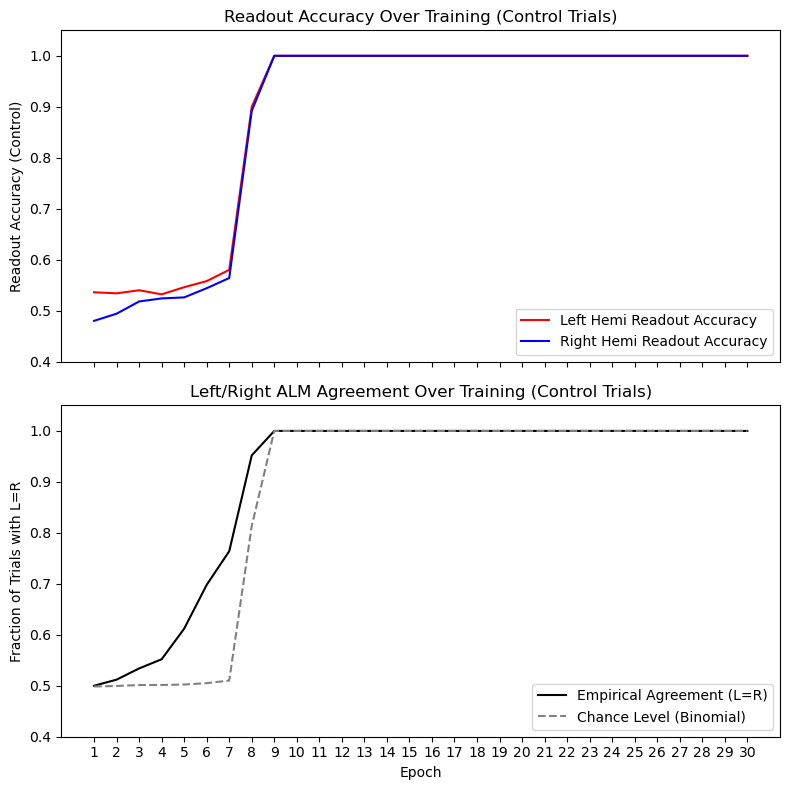

FileNotFoundError: [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_2/unfix_epoch_0/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'

In [9]:
exp = DualALMRNNExp()


for seed in [0,2]:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_256_random_seed_{}/unfix_epoch_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            exp.configs['unfix_epoch'],
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()